In [1]:
import os
import numpy as np
import pandas as pd
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt

In [2]:
def run_spercolation(input_path, output_path, ps):
    """
    Function that runs the street percolation.
    
    input_path: path of the edgelist file in the format (i,j,w)
    output_path: desideredpath for the output files
    ps: array of percolation thresholds
    """
    
    #################### Preparing output folders
    
    #directory for membership tables
    dir_res_memb = output_path+'/membTables/' 
    if not os.path.exists(dir_res_memb): os.makedirs(dir_res_memb)
        
    #directory for cluster size tables    
    dir_clust_size = output_path+"/cluster_sizes/"
    if not os.path.exists(dir_clust_size): os.makedirs(dir_clust_size)
        
    #file with global threshold info
    clusters_info_filename = output_path+"/clusters_info_p.txt"
    
    ########################################
    
    
    #Let us read the file that contains the list of nodes
    edgelist = pd.read_csv(input_path, sep=",")
    edgelist.columns = ['start_point','end_point','length']
    
    #Creating a file with global info on clusters given threshold p
    clusters_info_file = open(clusters_info_filename,'w')
    header = "threshold_p,n_clusters,LCC_id,LCC_size\n"
    clusters_info_file.write(header)
    
    for p in ps:
        print('p=', p)
    
        #find sub-matrix such that all weights <= threshold p
        filtered_p = edgelist[edgelist['length']<=p]
        #print 'filtered'
    
        #create graph
        G = nx.from_pandas_edgelist(filtered_p, source='start_point', target='end_point', edge_attr='length',
                                create_using=nx.Graph())
        #print 'graph created'
        
        #Creating a membership table file
        file_name = dir_res_memb+'membership_'+'p'+str(p)+'.txt'
        memb_table_file = open(file_name,'w')
        header = "node_id,cluster_id\n"
        memb_table_file.write(header)

        #Creating a cluster size file
        file_name = dir_clust_size+'clust_size_'+'p'+str(p)+'.txt'
        cluster_size_file = open(file_name,'w')
        header = "cluster_id,cluster_size\n"
        cluster_size_file.write(header)

        #Looping over connected components
        LCC_size = 0 #initial value to store the size of the LCC
        LCC_id = None
        for cluster_id, cluster_nodes in enumerate(nx.connected_components(G)):

            #Saving cluster size to file
            cluster_size = len(cluster_nodes)
            line = "%i,%i\n"%(cluster_id, cluster_size)
            cluster_size_file.write(line)

            #Updating the value for the size of the LCC (I want to find the id)
            if cluster_size>LCC_size:
                LCC_size = cluster_size
                LCC_id = cluster_id

            #Looping over nodes in clusters and saving to membership table file 
            for n in cluster_nodes:
                line = "%i,%i\n"%(n,cluster_id)
                memb_table_file.write(line)

        #Saving global clusters info to file
        NCC = cluster_id+1 #last id index +1 since it started from 0
        line = str(p)+',%i,%i,%i\n'%(NCC,LCC_id,LCC_size)
        clusters_info_file.write(line)
        print(NCC, 'connected components\n')

        memb_table_file.close()
        cluster_size_file.close()

    clusters_info_file.close()

    return None

In [3]:
def plot_percolation_transition(output_path, ax):
    
    #Reading data
    clusters_info_filename = output_path+"/clusters_info_p.txt"
    df = pd.read_csv(clusters_info_filename)
    
    x = df['threshold_p']
    y = df['LCC_size']/df['LCC_size'].max()
    
    #Plotting
    import matplotlib.ticker as ticker
    plt.rcParams['xtick.major.width'] = 1.2
    plt.rcParams['ytick.major.width'] = 1.2
    plt.rcParams['axes.linewidth'] = 1.2

    rangec = np.linspace(0.2,0.95,5)
    colors = [plt.cm.YlGnBu(i) for i in rangec]

    ax.plot(x, y,'o-', markersize=7, color=colors[1], clip_on=True, mfc=colors[1],
        mec=colors[1], lw=2, label='Size LCC')
    
    ax.set_xlabel(r'Percolation threshold, $p$ (meters)', size=16)
    ax.set_ylabel('Size LCC', size=16)
    ax.tick_params(axis='both', which='major', labelsize=16)

    plt.tight_layout()

### Load a cleaned networkx graph of London's street network

In [4]:
place = 'City of London, Greater London, England, United Kingdom'
G = ox.graph_from_place(place, network_type='drive', simplify=False)
#fig, ax = ox.plot_graph(G)

In [68]:
#for list of nodes: G.nodes

#### Save and reformat London's edgelist

In [5]:
nx.write_edgelist(G, os.path.relpath("run_spercolation_inputs/london.edgelist"))

In [6]:
with open(os.path.relpath("run_spercolation_inputs/london.edgelist")) as f:
    elist = []
    for item in f:
        elist.append(item)

https://stackoverflow.com/questions/46238813/osmnx-get-coordinates-of-nodes-using-osm-id

In [7]:
edf = pd.DataFrame(elist)
edf = edf[0].str.split('{', expand=True)
edf[[1,2]] = edf[1].str.split('length', expand=True)
edf = edf[[0,2]]
edf[['0a','0b', '0c']] = edf[0].str.split(' ', expand=True)
edf[['2a','2b']] = edf[2].str.split(' ', expand=True)
edf[['2b','2c']] = edf['2b'].str.split('}', expand=True)
edf = edf[['0a','0b','2b']]
edf.rename(columns={'0a': 'i', '0b': 'j', '2b': 'w'}, inplace=True)
edf.set_index('i', inplace = True)
edf.to_csv(os.path.relpath("run_spercolation_inputs/londonijw.csv"))

### Build array of percolation thresholds

In [8]:
thresholds = np.arange(5, 101, 1, dtype=int)

## Run Percolation

In [9]:
import time
start_time = time.time()

run_spercolation(os.path.relpath("run_spercolation_inputs/londonijw.csv"), 
                 os.path.relpath("run_spercolation_outputs"), 
                 thresholds)

print("--- %s seconds ---" % (time.time() - start_time))

p= 5
770 connected components

p= 6
824 connected components

p= 7
850 connected components

p= 8
842 connected components

p= 9
819 connected components

p= 10
771 connected components

p= 11
736 connected components

p= 12
704 connected components

p= 13
649 connected components

p= 14
614 connected components

p= 15
573 connected components

p= 16
535 connected components

p= 17
501 connected components

p= 18
468 connected components

p= 19
438 connected components

p= 20
406 connected components

p= 21
371 connected components

p= 22
338 connected components

p= 23
320 connected components

p= 24
299 connected components

p= 25
271 connected components

p= 26
251 connected components

p= 27
229 connected components

p= 28
214 connected components

p= 29
198 connected components

p= 30
183 connected components

p= 31
164 connected components

p= 32
146 connected components

p= 33
133 connected components

p= 34
119 connected components

p= 35
109 connected components

p= 36
98 conn

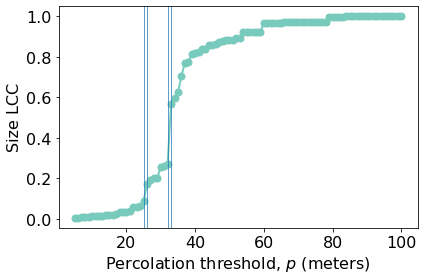

In [10]:
##### plot_percolation_transition(os.path.relpath("run_spercolation_outputs"), ax);

output_path = os.path.relpath("run_spercolation_outputs")
fig, ax = plt.subplots() #figsize=(5, 2.7)

#Reading data
clusters_info_filename = output_path + "/clusters_info_p.txt"
df = pd.read_csv(clusters_info_filename)

x = df['threshold_p']
y = df['LCC_size']/df['LCC_size'].max()

#Plotting
import matplotlib.ticker as ticker
plt.rcParams['xtick.major.width'] = 1.2
plt.rcParams['ytick.major.width'] = 1.2
plt.rcParams['axes.linewidth'] = 1.2

rangec = np.linspace(0.2,0.95,5)
colors = [plt.cm.YlGnBu(i) for i in rangec]

ax.plot(x, y,'o-', markersize=7, color=colors[1], clip_on=True, mfc=colors[1],
    mec=colors[1], lw=2, label='Size LCC')

ax.set_xlabel(r'Percolation threshold, $p$ (meters)', size=16)
ax.set_ylabel('Size LCC', size=16)
ax.tick_params(axis='both', which='major', labelsize=16)

plt.axvline(x=25, linewidth=0.7)
plt.axvline(x=26, linewidth=0.7)
plt.axvline(x=32, linewidth=0.7)
plt.axvline(x=33, linewidth=0.7)
plt.tight_layout()


In [11]:
jumps = [25, 26, 32, 33]

In [12]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

In [60]:
link = 'run_spercolation_outputs/membTables/membership_p20.txt'
memb = pd.read_csv(link)
memb.groupby('cluster_id').count().sort_values('node_id', ascending = False).iloc[[1]].node_id.values[0]

144

threshold = 25
LCC_id = 17, LCC_size = 397
LCC2_id = 2, LCC2_size = 277
threshold = 26
LCC_id = 2, LCC_size = 786
LCC2_id = 7, LCC2_size = 261
threshold = 32
LCC_id = 4, LCC_size = 1236
LCC2_id = 2, LCC2_size = 1174
threshold = 33
LCC_id = 2, LCC_size = 2576
LCC2_id = 1, LCC2_size = 230


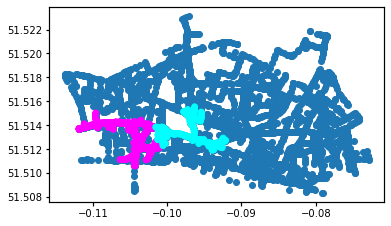

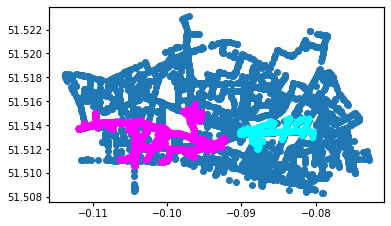

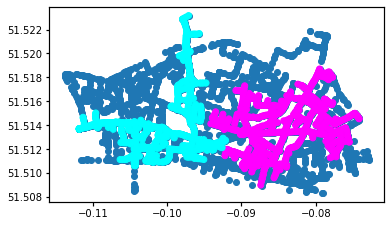

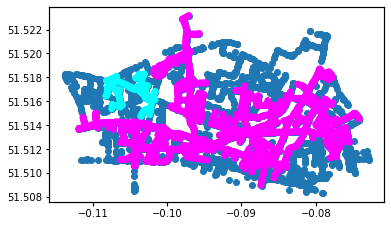

In [66]:
#Plot largest cluster in each jump
for moment in jumps:
    print('threshold = ' + str(moment))
    
    # find LCC_id in clusters_info_p.txt
    info = pd.read_csv(os.path.relpath("run_spercolation_outputs/clusters_info_p.txt"))
    lccid = info[info['threshold_p'] == moment]['LCC_id'].values[0]
    lccsize = info[info['threshold_p'] == moment]['LCC_size'].values[0]
    print('LCC_id = ' + str(lccid) +', LCC_size = ' + str(lccsize))
    
    # find 2nd LCC_id from membTables
    memb = pd.read_csv(os.path.relpath("run_spercolation_outputs/membTables/membership_p" + str(moment) + '.txt'))
    lccid2 = memb.groupby('cluster_id').count().sort_values('node_id', ascending = False).iloc[[1]].index[0]
    lccsize2 = memb.groupby('cluster_id').count().sort_values('node_id', ascending = False).iloc[[1]].node_id.values[0]
    print('LCC2_id = ' + str(lccid2) +', LCC2_size = ' + str(lccsize2))
    
    # find nodes in LCC_id in membTables
    lccnodes = memb[memb.cluster_id == lccid]
    lccnodes2 = memb[memb.cluster_id == lccid2]
    
    # plot nodes over london
    # fig, ax = ox.plot_graph(G.subgraph([1832666032, 1637578546, 8787692633]))
    #fig, ax = ox.plot_graph( G )
    #fig, ax = ox.plot_graph( G.subgraph( memb[memb['cluster_id']==lccid]["node_id"].tolist() ) )
    #nx.draw(S)
    
    # Plot clusters in each jump
    geo1 = pd.merge(gdf_nodes, lccnodes, right_on = 'node_id', left_on = 'osmid')
    geo2 = pd.merge(gdf_nodes, lccnodes2, right_on = 'node_id', left_on = 'osmid')
    base = gdf_nodes.plot()
    geo1.plot(ax = base, column = 'cluster_id', cmap='spring')
    geo2.plot(ax = base, column = 'cluster_id', cmap='cool')


### Parent-Child Relationships

In [14]:
for j in jumps:
    # tree level of this jump
    level = jumps.index(j)
    # retrieve the nodes in this jump
    jump = pd.read_csv(os.path.relpath("run_spercolation_outputs/membTables/membership_p"+str(j)+'.txt')) 
    jump['level'] = level
    jump = jump[['level', 'node_id', 'cluster_id']]
    
    # subset clusters of a minimum size
    sizes = pd.read_csv(os.path.relpath("run_spercolation_outputs/cluster_sizes/clust_size_p"+str(j)+'.txt'))
    clusters = sizes[sizes.cluster_size > 2] 
    nodes = pd.merge(jump, clusters, on='cluster_id').add_suffix(level) 
    
    # first jump (tree roottips, smallest cluster sizes)
    if level == 0:
        forest = nodes.copy()
        edgelist = pd.DataFrame(columns=['Child','Parent','Child_Level','Parent_Level'])
        sizelist = forest[['cluster_id' + str(level), 'cluster_size' + str(level), 'level' + str(level)]]
        sizelist = sizelist[sizelist.duplicated() == False]
        sizelist.columns = ['Cluster','Size','Level']
    
    else:
        # in the cluster forest, branches that don't make it to the apex die
        forest = pd.merge(forest, nodes, how = 'right',
                          left_on = forest.columns[1], right_on = nodes.columns[1])
        
        edgelist_ = forest[['cluster_id' + str(level - 1), 'cluster_id' + str(level), 'level' + str(level - 1), 'level' + str(level)]]
        edgelist_ = edgelist_[edgelist_.duplicated() == False]
        edgelist_.columns = ['Child','Parent','Child_Level','Parent_Level']
        edgelist = pd.concat([edgelist, edgelist_])
        
        sizelist_ = forest[['cluster_id' + str(level), 'cluster_size' + str(level), 'level' + str(level)]]
        sizelist_ = sizelist_[sizelist_.duplicated() == False]
        sizelist_.columns = ['Cluster','Size','Level']
        sizelist = pd.concat([sizelist, sizelist_])

In [15]:
sizelist['Cluster.'] = sizelist['Level'].astype(str) + '.' + sizelist['Cluster'].astype(str)
#edgelist[edgelist['Child']==edgelist['Parent']].sample(5)
edgelist['Child.'] = edgelist['Child_Level'].astype(str) + '.' + edgelist['Child'].astype(str)
edgelist['Parent.'] = edgelist['Parent_Level'].astype(str) + '.' + edgelist['Parent'].astype(str)

### Network

In [16]:
G = nx.from_pandas_edgelist(edgelist, 'Child.', 'Parent.')

In [17]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [18]:
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
from networkx import pygraphviz_layout

ImportError: cannot import name 'pygraphviz_layout' from 'networkx' (/opt/conda/envs/sds2021/lib/python3.9/site-packages/networkx/__init__.py)

In [ ]:
#pos = graphviz_layout(G, prog="dot")

nx.draw(G,
        pos = pygraphviz_layout(G),
        #with_labels = True,
        node_color='blue',
        font_color="white",
        font_weight='bold')
#plt.savefig('hierarchy.png')

In [ ]:
#https://networkx.org/documentation/stable/reference/algorithms/tree.html
print(
    nx.is_tree(G),
    nx.is_forest(G),
    #nx.is_arborescence(G),
    #nx.is_branching(G)
)
